In [3]:
import os, sys
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow as tf
import tensorflow_ranking as tfr
import keras.backend as K
import cv2
import numpy as np
import matplotlib.pyplot as plt# библиотеки вывода изображений
# from keras.utils import to_categorical#для преобразования ответов в классы
from keras.models import Sequential # импорт последовательной модели ИНС
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D # слои - входной, полносвязный, сверточный, 
#преобразующий 2D-данные в 1D-данные;
from keras.src.preprocessing.image import ImageDataGenerator

In [4]:
import torch
print('CUDA available' if torch.cuda.is_available() else 'CUDA not available')

CUDA available


С помощью класса ImageDataGenerator предоставленного tf.keras.
Он может считывать изображения с диска и препроцессировать их в нужные тензоры.
Он также настроит генераторы которые превратят эти изображения в batches тензоров (пакеты тензоров),что полезно при обучении сети.

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
valid_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_dir = "/home/dantedanger/CNN/input/train"
valid_dir = "/home/dantedanger/CNN/input/valid"
test_dir = "/home/dantedanger/CNN/input/test"

После определения генераторов для тренировочных и валидационных изображений,
Метод flow_from_directory загружает изображения с диска,
Применяет маштабирование и изменение размера изображений, приводя их к требуему размеру.

In [15]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=8,
                                               class_mode="categorical")

valid_data = valid_datagen.flow_from_directory(valid_dir,
                                               target_size=(224, 224),
                                               batch_size=8,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size=(224, 224),
                                               batch_size=8,
                                               class_mode="categorical")

labels = list(valid_data.class_indices.keys())

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


Создаем последовательную ИНС и добавляем 2 сверточных слоя, слой понижения размерности и полносвязный слой

In [16]:
model = Sequential()
model.add(Conv2D(128, kernel_size=3,activation='relu',input_shape=(224, 224, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64,activation='relu',kernel_size=3))
model.add(MaxPooling2D())
model.add(Conv2D(32,activation='relu',kernel_size=3))
model.add(MaxPooling2D())
model.add(Conv2D(16,activation='relu',kernel_size=3))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(53, activation="softmax"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 111, 111, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 32)        18464     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 26, 26, 32)       

Компилируем модель с оптимизатором Adam, функцией ошибки категориальной кроссэнтропии и метрикой точности - доля верных ответов

In [17]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy",
                       tfr.keras.metrics.MeanAveragePrecisionMetric(),
                       f1_metric
                       ])

history = model.fit(train_data,
                        epochs=10,
                        validation_data=valid_data)

Epoch 1/10


2023-11-24 02:56:55.081806: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


953/953 [==============================] - 218s 220ms/step - loss: 2.8197 - accuracy: 0.2727 - mean_average_precision_metric_4: 0.3997 - f1_metric: 0.1874 - val_loss: 1.5085 - val_accuracy: 0.5736 - val_mean_average_precision_metric_4: 0.7000 - val_f1_metric: 0.5553
Epoch 2/10
953/953 [==============================] - 208s 218ms/step - loss: 1.6008 - accuracy: 0.5710 - mean_average_precision_metric_4: 0.6770 - f1_metric: 0.5765 - val_loss: 1.1521 - val_accuracy: 0.6755 - val_mean_average_precision_metric_4: 0.7636 - val_f1_metric: 0.6775
Epoch 3/10
953/953 [==============================] - 209s 219ms/step - loss: 1.1418 - accuracy: 0.6941 - mean_average_precision_metric_4: 0.7741 - f1_metric: 0.7055 - val_loss: 0.9730 - val_accuracy: 0.7547 - val_mean_average_precision_metric_4: 0.8274 - val_f1_metric: 0.7749
Epoch 4/10
953/953 [==============================] - 208s 218ms/step - loss: 0.8141 - accuracy: 0.7667 - mean_average_precision_metric_4: 0.8358 - f1_metric: 0.7828 - val_loss:

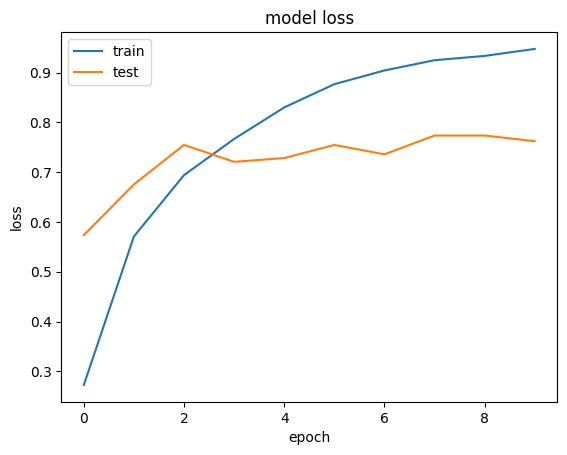

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

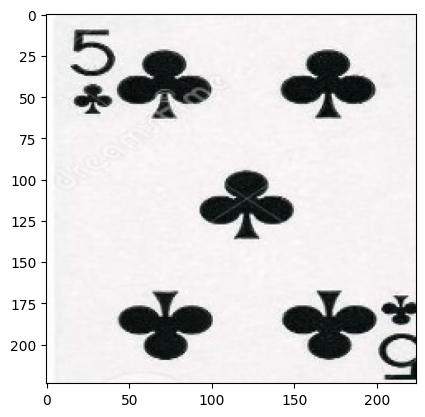

1/1 [==============================] - 1s 684ms/step
five of clubs


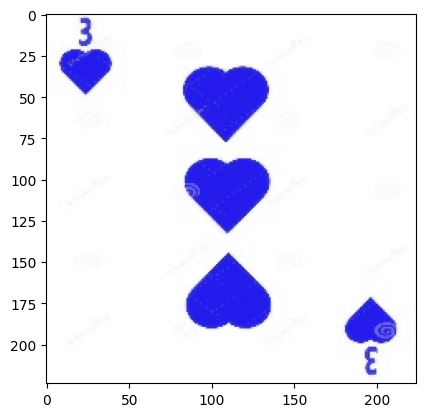

1/1 [==============================] - 0s 47ms/step
three of hearts


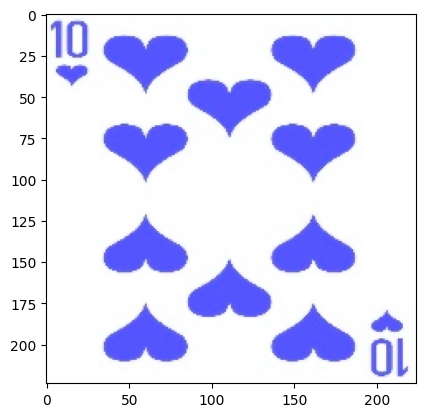

1/1 [==============================] - 0s 32ms/step
ten of hearts


In [19]:
img = cv2.imread('/home/dantedanger/CNN/input/valid/five of clubs/1.jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (224,224))
yhat = model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
print(labels[max_index])

img = cv2.imread('/home/dantedanger/CNN/input/valid/three of hearts/1.jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (224,224))
yhat = model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
print(labels[max_index])

img = cv2.imread('/home/dantedanger/CNN/input/valid/ten of hearts/1.jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (224,224))
yhat = model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
print(labels[max_index])